In [28]:
import pandas as pd
import mlflow
import io
import os
import seaborn as sns
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
warnings.filterwarnings("ignore")

In [6]:
col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
        'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd'];

col_per = ['LoanID','ReportingDate','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CurDelStatus','ModFlag','ZeroBalCode','ZeroBalEffDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','ForeclosureCost','RepairCost','AssetRecCost','MiscCostsPF',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OtherForePro','NonInterestUPB','PricipleForgiven','RMWPF',
          'FPWA','ServicingIndicator'];

In [7]:
os.chdir("/Users/devanshsethi/desktop/FNMA")

In [8]:
def read_txt(kind, year, quarter):
    type_dict = {'a': 'Acquisition',
                 'p': 'Performance'}

    col_dict = {'a': col_acq,
                'p': col_per}

    link = '{}_{}Q{}.txt'.format(type_dict[kind], year, quarter)

    #file = io.BytesIO(fs.cat(link))
    file = open(link,'r')
    chunk_s = 200000
    chunks = []

    for chunk in reader:
        chunks.append(chunk)

    df = pd.concat(chunks, axis=0)

    return df


In [9]:
# acq = pd.DataFrame()
# per = pd.DataFrame()
# for i in range(1,2):
#     acq = acq.append(read_txt('a',2004,i))
#     per = per.append(read_txt('p',2004,i))
# per.drop_duplicates(subset='LoanID', keep='last', inplace=True)
# df = pd.merge(acq, per, on='LoanID', how='inner')

In [10]:
# df.to_csv("Dataset.csv")

In [11]:
df = pd.read_csv("Dataset.csv")

In [12]:
df = df[['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm', 'OrDate',
    'FirstPayment','OrCLTV','NumBorrow','DTIRat','CreditScore',
    'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
    'Zip','RelMortInd','LoanAge','MonthsToMaturity','AdMonthsToMaturity','ForeclosureDate']]

In [13]:
df.rename(index=str, columns={"ForeclosureDate": 'Default'}, inplace=True)

In [14]:
df['Default'].fillna(0, inplace=True)
df.loc[df['Default'] != 0, 'Default'] = 1

df['Default'] = df['Default'].astype(int)

In [15]:
df.groupby("Default").count()

,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrDate,FirstPayment,OrCLTV,NumBorrow,...,LoanPurpose,PropertyType,NumUnits,OccStatus,PropertyState,Zip,RelMortInd,LoanAge,MonthsToMaturity,AdMonthsToMaturity
Default,,,,,,,,,,,,,,,,,,,,,
0,441459,441459,441459,441459,441459,441459,441459,441459,441449,441452,...,441459,441459,441459,441459,441459,441459,441459,441459,441428,436366
1,11015,11015,11015,11015,11015,11015,11015,11015,11015,11015,...,11015,11015,11015,11015,11015,11015,11015,11015,11010,11015


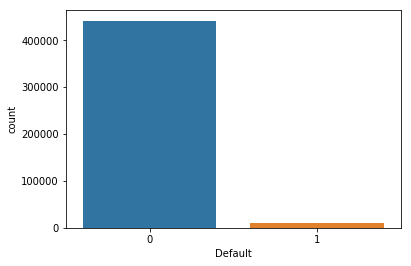

In [16]:
sns.countplot(df["Default"])

In [17]:
df.drop(['OrDate','FirstPayment','LoanID','Zip'], axis=1, inplace=True)

In [18]:
def getdummies(df):
    columns = df.columns[df.isnull().any()]
    nan_cols = df[columns]

    df.drop(nan_cols.columns, axis=1, inplace=True)

    cat = df.select_dtypes(include=['object'])
    num = df.drop(cat.columns, axis=1)

    data = pd.DataFrame()
    for i in cat.columns:
        tmp = pd.get_dummies(cat[i], drop_first=True)
        data = pd.concat([data, tmp], axis=1)

    df = pd.concat([num,data,nan_cols], axis=1).reset_index(drop=True)
    return df

In [19]:
def fillnan(df):
    columns = df.columns[df.isnull().any()]
    for name in columns:
        y = df.loc[df[name].notnull(), name].values
        X = df.loc[df[name].notnull()].drop(columns, axis=1).values
        X_test = df.loc[df[name].isnull()].drop(columns, axis=1).values
        if df[name].dtypes == 'object':
            model = LogisticRegression(random_state=0)
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
        else:
            model = LinearRegression()
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
    return df

### Subsetting dataset below, please remove if necessary

In [20]:
df = df[1:10000]

In [21]:
df = getdummies(df)

In [22]:
df = fillnan(df)

In [23]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN()

y = df['Default'].values
X = df.drop(['Default'], axis=1).values

print(list(X))

X_resampled, y_resampled = sm.fit_sample(X, y)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state=0)

with mlflow.startrun():    
    model = LogisticRegression(random_state = 0)
    model = model.fit(X_train, y_train)
    predict = model.predict(X_test)
    precision = average_precision_score(y_test, predict)
    
    mlflow.log_metric("Precision Score", precision)
    mlflow.sklearn.log_model(model, "Logistic_Model")

In [ ]:
# cm = confusion_matrix(y_test, predict).T
# cm = cm.astype('float')/cm.sum(axis=0)

# fig, ax = mp.subplots()
# sns.heatmap(cm, annot=True, cmap='Blues');
# ax.set_xlabel('True Label')
# ax.set_ylabel('Predicted Label')
# ax.xaxis.set_label_position('top')